## Optical Oscilloscope: Real-time filtering
---

This is the Jupyter Notebook for implementing my filtering algorithm with different parameters as well as comparison of the results with previously processed data.

### Imports

In [1]:
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from scipy import ndimage

#### Load and display the stack

In [2]:
file_path = 'data_from_paper.ome.tif'
stack = tf.imread(file_path)

<tifffile.TiffFile 'data_from_paper.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'data_from_paper.ome.tif'> MMStack series is missing files. Returning subset (9949, 1, 1, 1) of (10000, 1, 1, 1)


In [4]:
dark_region = tf.imread('dark_region.ome.tif')
dark_region = dark_region[0, :, :]

<tifffile.TiffFile 'dark_region.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'dark_region.ome.tif'> MMStack series is missing files. Returning subset (8085, 1, 1, 1) of (10000, 1, 1, 1)


Display the original image and a couple regions of interest that we will be working on. 

Text(0.5, 1.0, 'Cell 6')

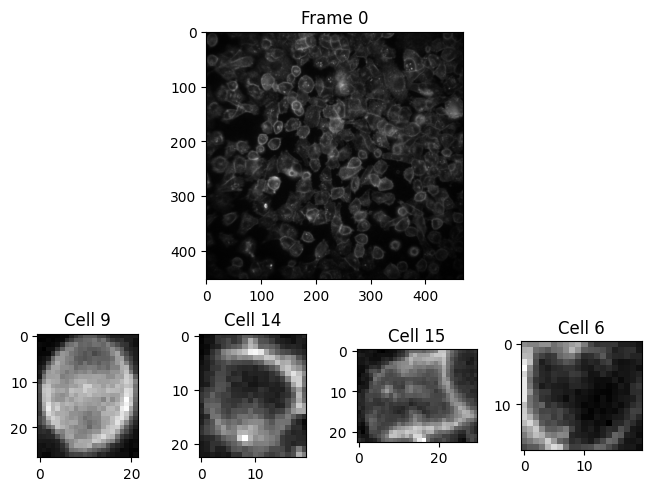

In [3]:
axd = plt.figure(layout='constrained').subplot_mosaic(
'''
AAAA
BCDE
''',
height_ratios=[2, 1],
width_ratios=[1, 1, 1, 1]
)

axd['A'].imshow(stack[0, :, :], cmap='gray')
axd['A'].set_title('Frame 0')
axd['B'].imshow(stack[0, 3:30, :22], cmap='gray') # Cell 9
axd['B'].set_title('Cell 9')
axd['C'].imshow(stack[0, 12:35, 100:120], cmap='gray') # Cell 14
axd['C'].set_title('Cell 14')
axd['D'].imshow(stack[0, 12:35, 160:190], cmap='gray') # Cell 15
axd['D'].set_title('Cell 15')
axd['E'].imshow(stack[0, :18, -20:], cmap='gray') # Cell 6
axd['E'].set_title('Cell 6')

### Filtering Algorithm

#### Global Variables

In [8]:
dark_value = np.mean(dark_region[:50, :50])

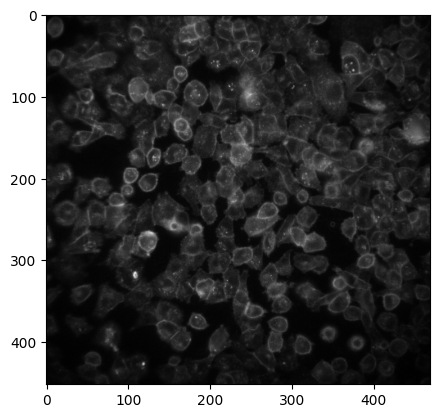

In [10]:
plt.imshow(stack[0, :, :] - dark_value, cmap='gray')
plt.show()

#### Function Definition

In [20]:
def filtering(x, y, batch_size=100):
    batch_size = 100  # Adjust the batch size as needed
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = [np.median(stack[i, x, y]) for i in range(len(stack))]

    result_data = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)

        processed_time_series_batch = np.zeros((end_index - start_index))
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index):
            # Your processing code for each index within the batch
            

            # Perform filtering
            filtered = ndimage.uniform_filter(raw_time_series[:index + 1], size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            processed_time_series_batch[index - start_index] = filtered[index]
            
            if index % 2 == 0:
                blue_unf = raw_time_series[index]
                green_unf = raw_time_series[index - 1]
                blue_f = processed_time_series_batch[index - start_index]
                green_f = processed_time_series_batch[index - start_index - 1]

                # Avoid division by zero
                blue_channel = np.divide(blue_unf, blue_f, out=np.zeros_like(blue_f), where=blue_f != 0)
                green_channel = np.divide(green_unf, green_f, out=np.zeros_like(green_f), where=green_f != 0)
                frame = np.divide(blue_channel, green_channel, out=np.zeros_like(green_channel), where=green_channel != 0)

                idx = int(index / 2)
                result_data_batch[idx] = frame

        result_data.append(result_data_batch)
    return result_data

Now let's try the algorithm on a single pixel. The pixel we will track will correspond to a pixel in Cell 9.

In [21]:
result_data = filtering(10, 10) # Corresponds to a pixel in Cell 9

In [22]:
# Drop null values
for i in range(len(result_data)):
    result_data[i] = result_data[i][result_data[i] != 0]

In [23]:
result_data = np.concatenate(result_data) # Combine to one np array

In [24]:
result_data

array([0.823697  , 0.80349964, 0.80684394, ..., 0.80646921, 0.84614267,
       0.84400625])

Now let's plot the time series and compare it with the results from the paper. 

In [25]:
# First, define function for demean and offset-ing (?)
def prepare_plot(tseries, sigma):
    tseries_gauss = ndimage.gaussian_filter(tseries, sigma=sigma)
    tseries_gauss_demean = tseries_gauss - np.mean(tseries_gauss)
    offset = 1 - np.mean(tseries_gauss_demean)
    result_tseries = tseries_gauss_demean + offset

    return result_tseries

In [47]:
# Load data from paper
data = pd.read_csv('cancer_20201218_slip1_area4_long_acq_long_acq_blue_0.0318_green_0.0772_heated_to_37_TTX_washout_1_active_timeseries.csv')
data = data.drop(data.columns[0], axis=1)
cell = 9 # Choose cell of interest
y_axis = data.iloc[15].to_list()

In [48]:
y_axis

[0.9977642929081856,
 0.9975538244521808,
 0.9971449883295151,
 0.996567764718876,
 0.9958778368157246,
 0.9951568689665504,
 0.9944982381130512,
 0.9939813151575372,
 0.9936457501465225,
 0.9934828017998548,
 0.9934558250686022,
 0.993534236452418,
 0.993720063889356,
 0.9940445595249644,
 0.9945399021566648,
 0.9952043391975844,
 0.9959856075147688,
 0.9967943069525936,
 0.997534270588287,
 0.9981330650501216,
 0.9985561756348518,
 0.9988051886448752,
 0.9989049184711548,
 0.9988826529104912,
 0.9987566873912944,
 0.9985381841259986,
 0.9982488314963442,
 0.9979397215465124,
 0.99769029791814,
 0.9975777627151328,
 0.9976320446198078,
 0.997810667760038,
 0.9980160982888784,
 0.99814635327905,
 0.9981473527478671,
 0.9980326531531238,
 0.9978647669616272,
 0.9977149223441332,
 0.9976259371792696,
 0.9975960001035724,
 0.9975896094935832,
 0.9975662630571402,
 0.997506395940709,
 0.99742127156613,
 0.9973417952485436,
 0.9973002407652076,
 0.997318297450123,
 0.9974061528019298,
 0.99

In [27]:
result_tseries = prepare_plot(result_data, 12)

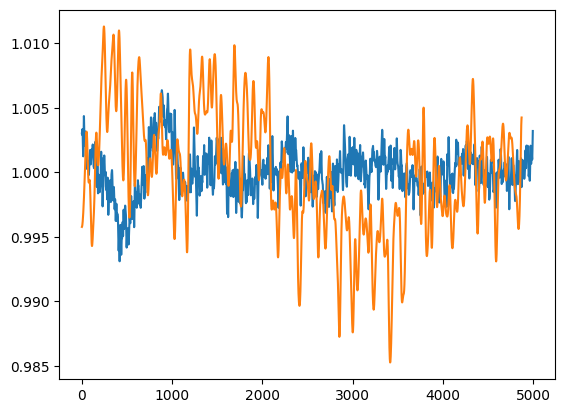

In [35]:
plt.plot(y_axis)
plt.plot(result_tseries)
plt.show()

Now take the median pixel value within the ROI, this might not give the best results just yet as the ROI is not circular (i.e. not bordering cell edges).

In [60]:
# Tweak the function
def filtering(x1, x2, y1, y2, batch_size):
    # Adjust the batch size as needed
    total_indices = len(stack) # stack is a global variable
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = [np.median(stack[i, x1:x2, y1:y2]) for i in range(len(stack))]

    result_data = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)

        processed_time_series_batch = np.zeros((end_index - start_index))
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index):
            # Your processing code for each index within the batch
            

            # Perform filtering
            filtered = ndimage.uniform_filter(raw_time_series[:index + 1], size=1000, mode='nearest', # Need to QUANTIFY analytically how it could be similar
                                            origin=origin)
            processed_time_series_batch[index - start_index] = filtered[index]
            
            if index % 2 == 0:
                blue_unf = raw_time_series[index]
                green_unf = raw_time_series[index - 1]
                blue_f = processed_time_series_batch[index - start_index]
                green_f = processed_time_series_batch[index - start_index - 1]

                # Avoid division by zero
                blue_channel = np.divide(blue_unf, blue_f, out=np.zeros_like(blue_f), where=blue_f != 0)
                green_channel = np.divide(green_unf, green_f, out=np.zeros_like(green_f), where=green_f != 0)
                frame = np.divide(blue_channel, green_channel, out=np.zeros_like(green_channel), where=green_channel != 0)

                idx = int(index / 2)
                result_data_batch[idx] = frame

        result_data.append(result_data_batch)
    return result_data

In [46]:
result_data_14 = filtering(12, 35, 100, 120)
# Drop null values
for i in range(len(result_data_14)):
    result_data_14[i] = result_data_14[i][result_data_14[i] != 0]
result_data_14 = np.concatenate(result_data_14) # Combine to one np array
result_data_14

array([0.89622683, 0.90766212, 0.90032492, ..., 0.91695882, 0.91843562,
       0.91905961])

In [49]:
result_tseries = prepare_plot(result_data_14, 3)

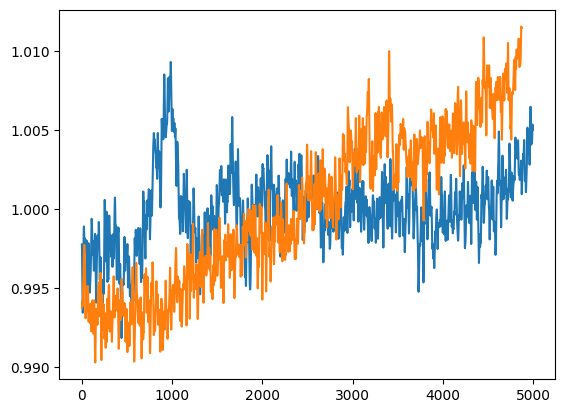

In [50]:
plt.plot(y_axis)
plt.plot(result_tseries)
plt.show()

I can't lie it doesn't look quite right, let's try using a larger batch size.

In [65]:
result_data_14 = filtering(12, 35, 100, 120, 100)
for i in range(len(result_data_14)):
    result_data_14[i] = result_data_14[i][result_data_14[i] != 0]
result_data_14 = np.concatenate(result_data_14) # Combine to one np array
result_data_14

array([0.89622683, 0.90766212, 0.90032492, ..., 0.91695882, 0.91843562,
       0.91905961])

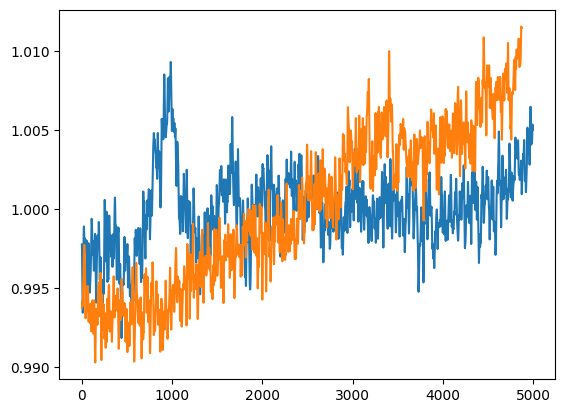

In [66]:
result_tseries = prepare_plot(result_data_14, 3)
plt.plot(y_axis)
plt.plot(result_tseries)
plt.show()


It seems (?) to be doing what it is supposed to be doing after like frame 2500. Let's do all of our ROIs and plot them.

In [ ]:
def workflow(result_data, rowtup, coltup, batch_size, sigma):
    (x1, x2) = rowtup
    (y1, y2) = coltup
    result_data = filtering(x1, x2, y1, y2, batch_size)
    for i in range(len(result_data)):
        result_data[i] = result_data[i][result_data[i] != 0]
        result_data = np.concatenate(result_data)
    result_tseries = prepare_plot(result_data, sigma)
    return result_tseries

In [ ]:
row_tuples = [(3, 30), (12, 35), (12,35), (0, 18)]
col_tuples = [(0, 22), (100, 120), (160, 190), (-20, 0)]
batch_sizes = [100, 1000, len(stack)]
sigmas = [3, 12]
